In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

import pickle

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [3]:
nb_houses = 20

In [4]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


In [5]:
_individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [6]:
individuals = _individuals.copy()

# Fix variables
deltat = timedelta(minutes=15)

# Training = 31 days + 1 day for lagged values
training = timedelta(days=31)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=7)

# When do we calibrate
start_calibrate = start - timedelta(days=2)
end_calibrate = start - deltat
start_training_to_calibrate = start_calibrate - training
end_training_to_calibrate = start_calibrate - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
individuals = individuals.loc[start_training_to_calibrate-timedelta(days=1):end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

sub_house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]

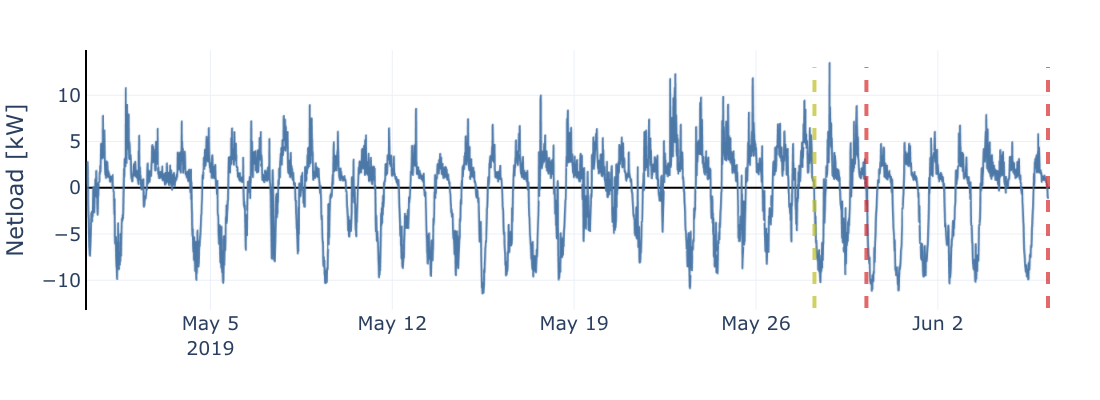

In [7]:
graph = individuals.loc[start-training+timedelta(days=1):end-timedelta(days=7), sub_house_ids].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=2)

# Red dashed line
fig.add_shape(
 type='line',
 x0=start, x1=start, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

# Red dashed line
fig.add_shape(
 type='line',
 x0=start+full_horizon-deltat,
 x1=start+full_horizon-deltat, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

# Red dashed line
fig.add_shape(
 type='line',
 x0=start_calibrate,
 x1=start_calibrate, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(188, 189, 34, 0.7)'})

fig.update_layout(
    layout,
    height=400,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")
#fig.write_image(f"results/mpc_inputs.svg")

# ------ Section by-passed with (batch_forecast.py)

# Forecast model

In [14]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm.notebook import tqdm

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None, 
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0):
        
        self._output = output
        self._model = Prophet(
            growth='flat',
            yearly_seasonality=False,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=False,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"], 
                prior_scale=reg["prior_scale"])

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

def lag_values(df, nb_lag, output_col):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp[output_col].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(df, start_training, end_training, horizon,
                                   deltat, end_complete_pred, freq, output_col,
                                   regressors, nb_lag, seasonality_prior_scale=1.0,
                                   disable_progress_bar=False, daily_seasonality="auto"):
    """
    Train a GAM and predict for horizon T
    Shift prediction start and predict over T again.
    
    results : [pd.DataFrame] One frame per prediction.
    """
    
    inputs = [reg["name"] for reg in regressors]
    results = []
    model = GAM(output_col, regressors, daily_seasonality=daily_seasonality,
                seasonality_prior_scale=seasonality_prior_scale)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag, output_col)
    model.fit(tmp.loc[start_training:end_training])
    
    # Number of forecast where we have access to actual data
    forecast_freq = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    for start_prediction in tqdm(forecast_freq, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon

        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag, output_col)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.at[step, f"t-{n}"]):
                    tmp.at[step, f"t-{n}"] = tmp_results[step_i-n]
            
            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, output_col])
            
        results.append(pd.DataFrame(index=horizon_spam, data={output_col: tmp_results}))
    return results, model

def model_3(graph, start_training, end_training, horizon,
            deltat, end_complete_pred, freq, output_col, scenario):
    
    regressors = [{"name": "pv_1kw", "prior_scale": scenario["PRIOR_GHI"]}]

    for hour in range(0, 24):
        regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

    nb_lag = list(range(1, scenario["NB_LAG"] + 1))
    for n in nb_lag:
        regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

    results, _ = predict_n_periods_with_autoreg(
        graph, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col,
        regressors, 
        nb_lag=nb_lag,
        seasonality_prior_scale=scenario["PRIOR_SEASON"],
        daily_seasonality=scenario["DAILY_FOURIER"],
        disable_progress_bar=True)
    return results

def calibrate(df, individuals, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col):
    gofs = []
    reference = {
         "NB_LAG": 4,
         "PRIOR_GHI": 3.0,
         "PRIOR_LAG": 10.0,
         "PRIOR_HOUR": 10.0,
         "PRIOR_SEASON": 1.0,
         "DAILY_FOURIER": "auto"}
    
    scenarios = [reference]
    for i in range(1, 14 + 1):  #  range(1, 24 + 1)
        scenarios.append(dict(reference))
        scenarios[-1]["NB_LAG"] = i
    
    for i in [1, 5, 8, 10, 15, 20]:
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_GHI"] = i   
  
    for i in [1, 5, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_LAG"] = i 

    for i in [8, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_HOUR"] = i 

    for i in [3]:  #  [3, 5, 8, 10, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_SEASON"] = i           
    
    graph = individuals[[output_col]].copy()
    graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    
    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)
    
    for scenario in tqdm(scenarios, desc="Calibration :"):
        results = model_3(graph, start_training, end_training, horizon,
                    deltat, end_complete_pred, freq, output_col, scenario)
        
        results = pd.concat(results, axis=0)
        gofs.append(get_gof(individuals, results, output_col, output_col))
        #tmp_gof = []
        #for result in results:
        #    tmp_gof.append(get_gof(individuals, result, output_col, output_col))
        #gofs.append(np.mean(tmp_gof))
        
    results = pd.DataFrame(data=scenarios)
    results["gof"] = gofs
    return results

# Calibrate

In [ ]:
print(f"start_training_to_calibrate={start_training_to_calibrate}")
print(f"end_training_to_calibrate={end_training_to_calibrate}")
print(f"start_calibrate={start_calibrate}")
print(f"end_calibrate={end_calibrate}")

In [ ]:
horizon = timedelta(hours=2, minutes=45)
freq = f"180T"

In [ ]:
import warnings

full_scores = []
best_scores = []

for house_id in house_ids[0:5]:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        results = calibrate(df, individuals, 
                            start_training_to_calibrate, 
                            end_training_to_calibrate, 
                            horizon, 
                            deltat, 
                            end_calibrate, 
                            freq, house_id)
    
    score = results.copy()
    full_scores.append(score)
    best_scores.append(score.nlargest(columns="gof", n=1).to_dict('records')[0])
    print(best_scores[-1])


In [ ]:
pd.DataFrame(index=house_ids[0:5], data=best_scores)

# Default calibration

In [8]:
default_calibration = {
                 "NB_LAG": 10,
                 "PRIOR_GHI": 3.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"    
}
best_parameters = {name:dict(default_calibration) for name in sub_house_ids}

# Forecast at freq=$X$ --> full week

In [10]:
start_training = start - training
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)

freqs = ["2D", "1D", "12H", "6H", "3H", "1H", "15T"]
freq_deltas = [timedelta(days=2) - deltat,
               timedelta(days=1) - deltat,
               timedelta(hours=12) - deltat,
               timedelta(hours=6) - deltat,
               timedelta(hours=3) - deltat,
               timedelta(hours=1) - deltat,
               timedelta(minutes=15) - deltat
              ]

In [ ]:
house_forecast = {}

for freq in freqs:
    print(f"Freq = {freq}")
    house_forecast[freq] = {}
    
    for house_id in tqdm(house_ids[0:5], desc="House #"):

        graph = individuals[[house_id]].copy()
        graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

        graph["_datetime"] = graph.index
        for hour in range(0, 24):
            graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
        graph.drop(columns="_datetime", inplace=True)

        results = model_3(graph, start_training, end_training, horizon,
                    deltat, end_complete_pred, freq, house_id, best_parameters[house_id])

        house_forecast[freq][house_id] = [res.copy() for res in results]
    print("")

In [ ]:
# Reformat as a dict of freq with a list of pd.DataFrame with all houses.
house_forecast_list = {}

for freq in freqs:
    house_forecast_list[freq] = []
    
    for i in range(0, len(house_forecast[freq][house_ids[0]])):
        tmp = pd.concat([house_forecast[freq][house_id][i] for house_id in house_ids[0:5]], axis=1)
        house_forecast_list[freq].append(tmp)
        
# Store data (serialize)
with open('house_forecast_list.pickle', 'wb') as handle:
    pickle.dump(house_forecast_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ------ End section by-passed with (batch_forecast.py)

In [11]:
house_forecast = {}

for freq in freqs:
    with open(f'tmp_forecasts/house_forecast_{freq}.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
    house_forecast[freq] = unserialized_data
    
# Reformat as a dict of freq with a list of pd.DataFrame with all houses.
house_forecast_list = {}

for freq in freqs:
    house_forecast_list[freq] = []
    
    for i in range(0, len(house_forecast[freq][sub_house_ids[0]])):
        tmp = pd.concat([house_forecast[freq][house_id][i] for house_id in sub_house_ids], axis=1)
        house_forecast_list[freq].append(tmp)

In [ ]:
## Load data (deserialize)
#with open('house_forecast_list.pickle', 'rb') as handle:
#    unserialized_data = pickle.load(handle)

### Profiles

15T


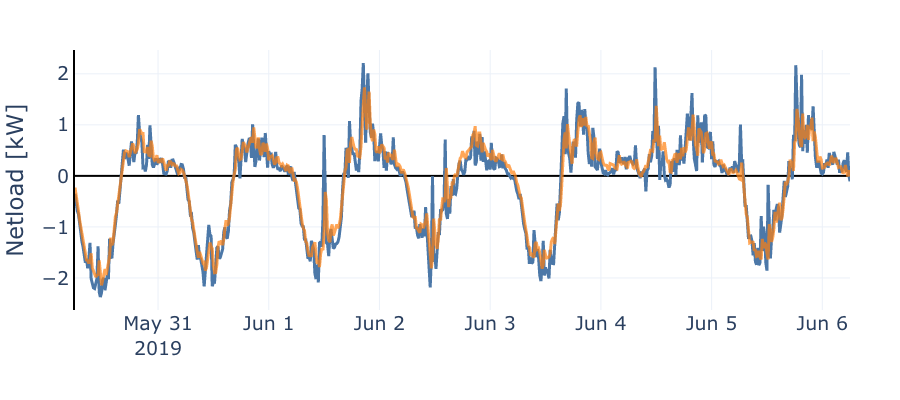

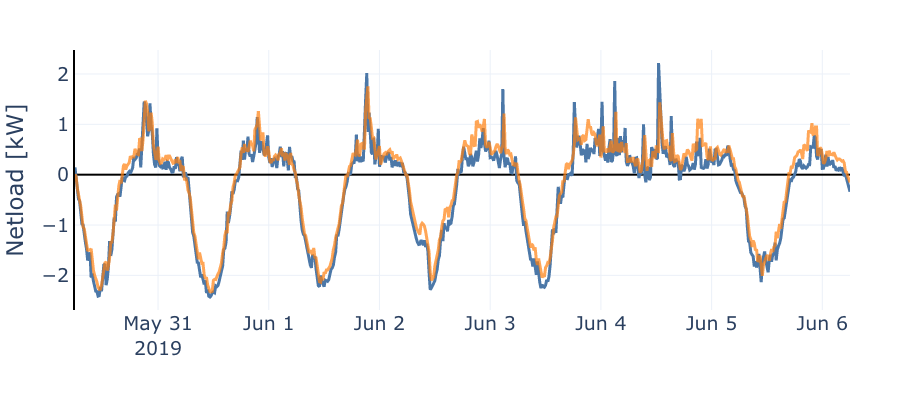

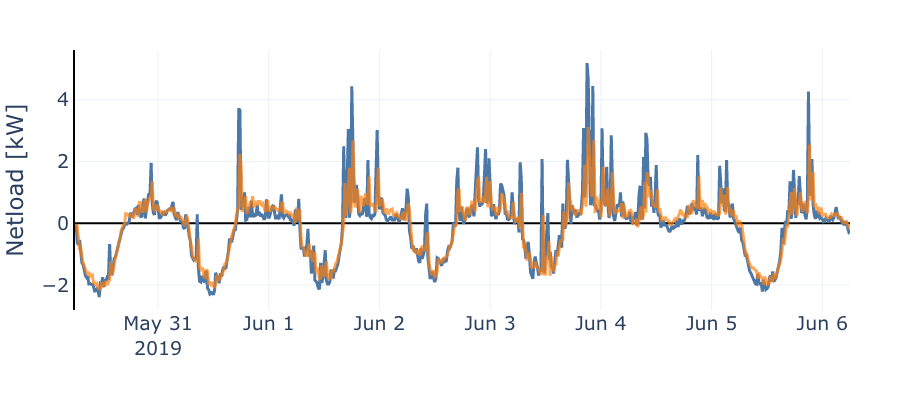

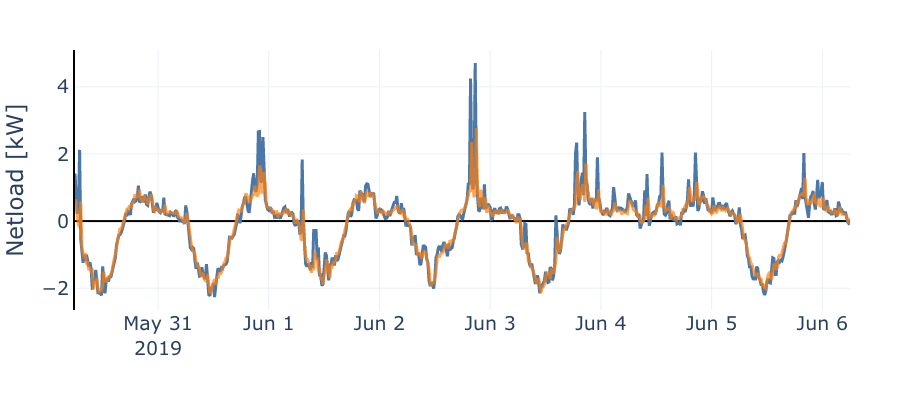

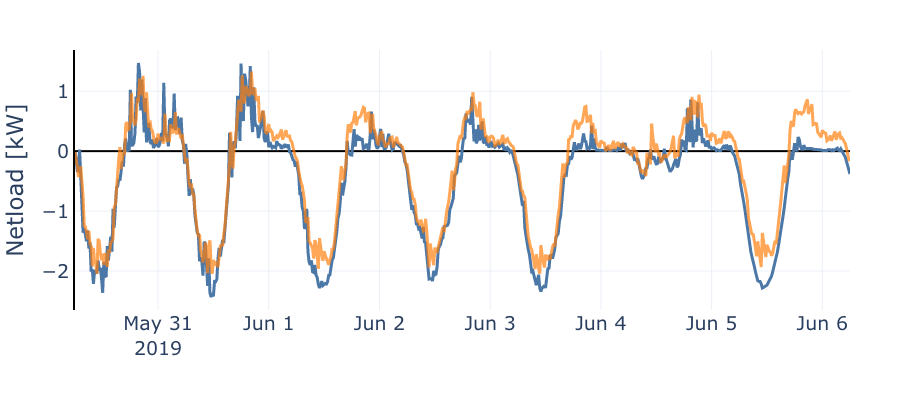

In [12]:
f = -1
freq = freqs[f]
freq_delta = freq_deltas[f]
print(freq)

for house_id in sub_house_ids:
    graph = individuals.loc[start:end_complete_pred, [house_id]].copy()
    graph.columns = ["Ref"]

    fig = px.line(graph)
    fig.data[0].update(line_width=3)
    
    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)

    trace = px.line(graph[house_id].loc[start:end_complete_pred]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(line_width=3, line_color="rgba(255, 127, 14, 0.7)")

    fig.update_layout(
        layout,
        height=400,
        width=900,
        showlegend=False,
        xaxis_title="",
        yaxis_title="Netload [kW]",
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show(renderer="png")
    fig.write_image(f"results/_MPC_freq={freq}_horizon=2d_{house_id}.svg")

### Goodness of fit

In [15]:
gofs = {house_id: list() for house_id in sub_house_ids}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)        
    
    for house_id in sub_house_ids:
        gofs[house_id].append(get_gof(individuals, graph.loc[start:end_complete_pred, :], house_id, house_id))

gofs = pd.DataFrame(index=freqs, data=gofs)
gofs

,2000989,2000964,2000926,2001139,2000960
2D,54.649605,55.898589,39.311504,55.307712,39.244447
1D,54.716014,55.920420,39.353404,55.336413,39.258646
12H,55.121319,56.162812,39.336918,55.477070,39.901513
6H,55.666209,56.288712,39.678346,55.559861,41.076052
3H,56.877791,57.753344,40.981179,55.487908,43.428659
1H,60.140377,62.676010,42.851582,57.194350,49.187925
15T,64.049201,71.604030,46.645096,59.921770,63.870236


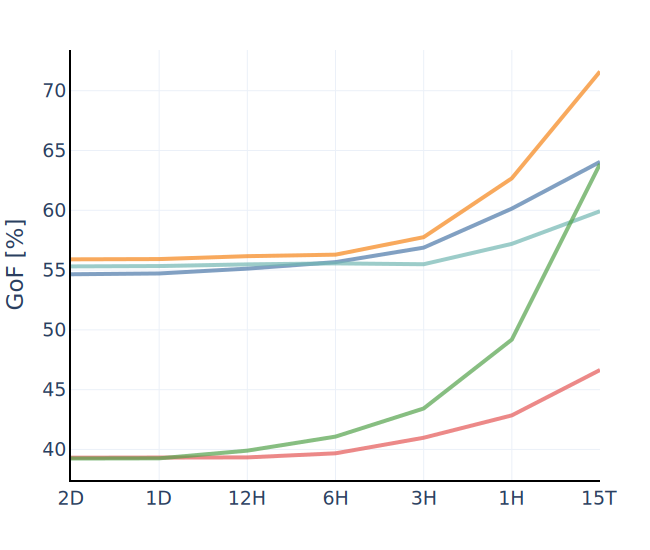

In [16]:
fig = px.line(gofs)
fig.update_traces(line_width=4, opacity=0.7)
fig.update_layout(
    layout,
    height=550,
    width=650,
    showlegend=False,
    xaxis_title="",
    yaxis_title="GoF [%]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/gof.svg")

# Optimize at freq=$X$

In [17]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
#--->?? #m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [18]:
freqs

['2D', '1D', '12H', '6H', '3H', '1H', '15T']

In [19]:
[(a + deltat).total_seconds() / 3600 for a in freq_deltas]

[48.0, 24.0, 12.0, 6.0, 3.0, 1.0, 0.25]

In [20]:
netload_freq = {}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    
    netload_freq[freq] = pd.concat(tmp, axis=0)

In [21]:
schedules_concat = {}
energy_concat = {}
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
                          verbose=False, only_return_schedules=False)

for freq, freq_delta in zip(freqs, freq_deltas):
    print(f"Freq = {freq}")
    schedules_concat[freq] = []
    energy_concat[freq] = []
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in tqdm(enumerate(date_range), desc="Opti #", total=nb_iteration):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = netload_freq[freq].loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        schedules_concat[freq].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        energy_concat[freq].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    schedules_concat[freq] = pd.concat(schedules_concat[freq], axis=0)
    energy_concat[freq] = pd.concat(energy_concat[freq], axis=0)
    print("")

Freq = 2D


Opti #:   0%|          | 0/4 [00:00<?, ?it/s]


Freq = 1D


Opti #:   0%|          | 0/8 [00:00<?, ?it/s]


Freq = 12H


Opti #:   0%|          | 0/15 [00:00<?, ?it/s]


Freq = 6H


Opti #:   0%|          | 0/29 [00:00<?, ?it/s]


Freq = 3H


Opti #:   0%|          | 0/57 [00:00<?, ?it/s]


Freq = 1H


Opti #:   0%|          | 0/169 [00:00<?, ?it/s]


Freq = 15T


Opti #:   0%|          | 0/673 [00:00<?, ?it/s]

### Perfect optimization

In [22]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq="2D"), desc="Optimization #"):
    
    tmp_netload = individuals.loc[opti_start:opti_start+horizon+deltat, sub_house_ids].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    battery_time = opti_start + horizon + deltat
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])
    
    perfect_schedules_concat.append(schedule["schedules"].loc[opti_start:opti_start+horizon].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].loc[opti_start:opti_start+horizon].copy())
    perfect_communityimport_concat.append(schedule["community_import"].loc[opti_start:opti_start+horizon].copy())

perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

Optimization #:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
def community_import_graph():
    graph = perfect_communityimport_concat.loc[:end_complete_pred].copy()
    graph.columns = ["check_perfect"]

    graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)
    graph["pv_production_kw"] = pv_size * len(sub_house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    print(f"Check PV size = {pv_size} kWp")

    graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
    graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
    
    for freq in freqs:
        graph[f"{freq}"] = (graph["Total"] - graph["pv_production_kw"] + schedules_concat[freq].sum(axis=1)).clip(lower=0)
    
    np.testing.assert_almost_equal(
        graph["Perfect"].sum(), graph["check_perfect"].sum(),
        decimal=7, verbose=True)
    graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)
    return graph

Check PV size = 3 kWp


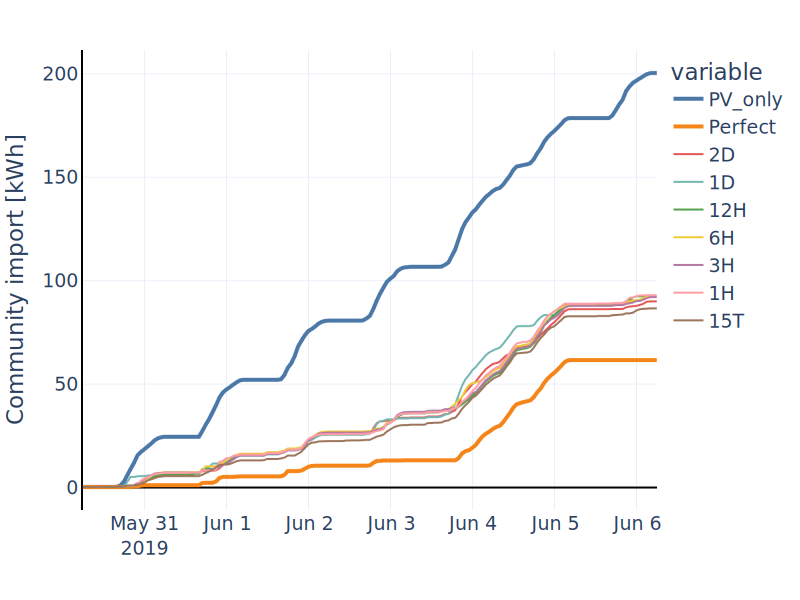

                        PV_only    Perfect         2D         1D       12H  \
Index                                                                        
2019-06-06 06:00:00  200.357695  61.605633  89.960656  92.523419  92.61755   

                            6H         3H         1H        15T  
Index                                                            
2019-06-06 06:00:00  92.078237  92.058538  92.975729  86.584097  


In [24]:
graph = community_import_graph()
graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end_complete_pred, ["PV_only", "Perfect"] + freqs])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/cumsum_community_import_all_freq.svg")
print(graph.tail(1))

In [25]:
(graph.iloc[-1]["PV_only"] - graph.iloc[-1]["15T"]) * 100 / (graph.iloc[-1]["PV_only"] - graph.iloc[-1]["Perfect"])

81.99777097222446

In [26]:
(graph.iloc[-1]["PV_only"] - graph.iloc[-1]["2D"]) * 100 / (graph.iloc[-1]["PV_only"] - graph.iloc[-1]["Perfect"])

79.5642511355404

2D


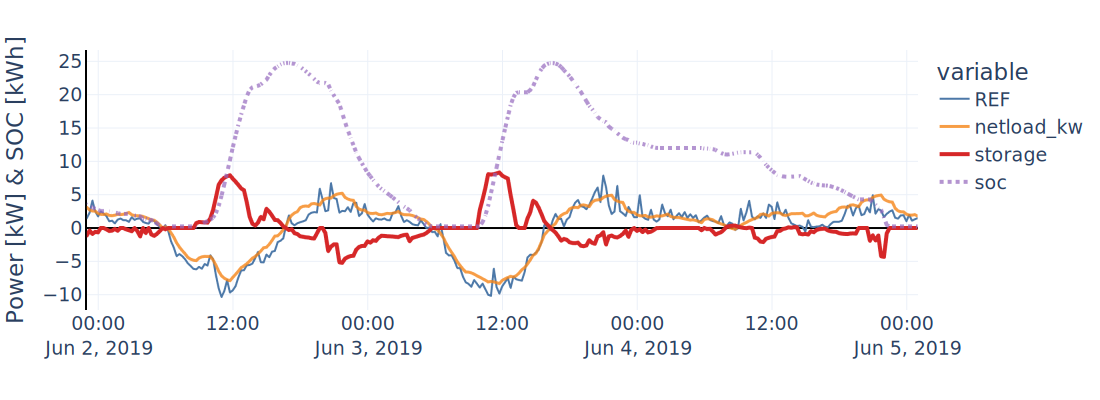

15T


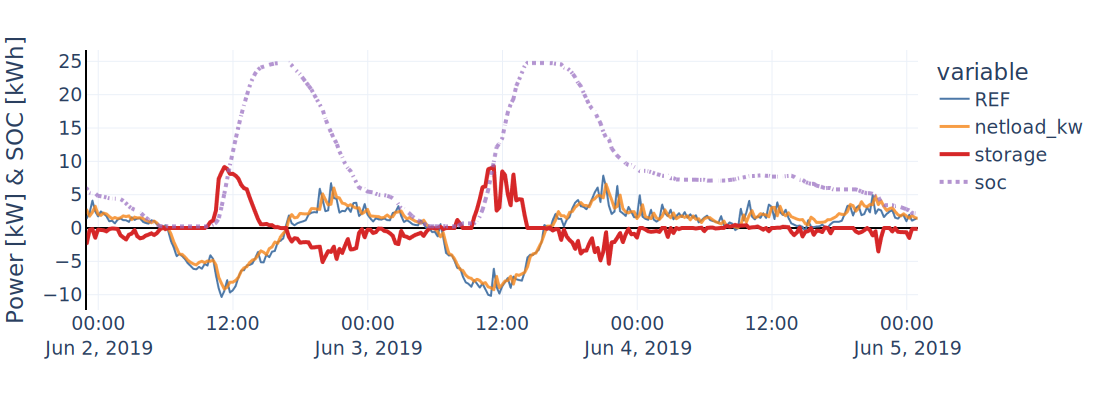

In [27]:
f1 = 0
f2 = -1

for freq, freq_delta in zip([freqs[f1], freqs[f2]], [freq_deltas[f1], freq_deltas[f2]]):
    print(freq)
    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)
    graph = graph.loc[:end_complete_pred, :]
    graph = graph.loc[datetime(2019, 6, 1, 23, 0, 0):datetime(2019, 6, 5, 1, 0, 0), :]

    graph["netload_kw"] = graph.loc[:end_complete_pred, sub_house_ids].sum(axis=1)
    graph.drop(sub_house_ids, axis=1, inplace=True)

    graph["REF"] = individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)

    graph["storage"] = schedules_concat[freq].sum(axis=1)
    graph["soc"] = energy_concat[freq].sum(axis=1)

    fig = px.line(graph, y=["REF", "netload_kw", "storage", "soc"])
    fig.data[1].update(line_width=3, opacity=0.8)
    fig.data[2].update(line_width=4, 
                       line_color="rgba(214, 39, 40, 1.0)")
    fig.data[3].update(line_width=4, 
                       line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
    fig.update_layout(
        layout,
        height=400,
        width=1100,
        showlegend=True,
        xaxis_title="",
        yaxis_title="Power [kW] & SOC [kWh]",
        yaxis_dtick=5,
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show()
    #fig.write_image(f"results/optimal_schedule_{freq}.svg")

## Compare in €

In [28]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [29]:
freqs

['2D', '1D', '12H', '6H', '3H', '1H', '15T']

In [30]:
_start = end_training + deltat
_end = end_complete_pred

In [31]:
for freq in freqs:
    graph = schedules_concat[freq].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    print(f"Forecast at {freq} cost = {np.round(forecast_cost, 2)} €")

Forecast at 2D cost = 17.43 €
Forecast at 1D cost = 17.92 €
Forecast at 12H cost = 17.8 €
Forecast at 6H cost = 17.79 €
Forecast at 3H cost = 17.68 €
Forecast at 1H cost = 17.73 €
Forecast at 15T cost = 16.56 €


In [32]:
graph = perfect_schedules_concat.copy()
graph.columns = sub_house_ids
for col in graph.columns:
    graph[col] += individuals.loc[_start:_end, col]

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Optimization cost = {np.round(forecast_cost, 2)} €")

Optimization cost = 11.61 €


In [33]:
graph = individuals.loc[_start:_end, sub_house_ids].copy()

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"PV only cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="1D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 1d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="2D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 2d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="365D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical cost = {np.round(forecast_cost, 2)} €")

PV only cost = 35.33 €
Theoretical 1d cost = 7.89 €
Theoretical 2d cost = 2.33 €
Theoretical cost = 0.0 €


In [34]:
np.round((35.33 - 17.43) * 100 / (35.33 - 11.61), 2)

75.46

In [35]:
np.round((35.33 - 16.56) * 100 / (35.33 - 11.61), 2)

79.13

# Influence of starting point on perfect forecast

In [36]:
p_schedules_concat = {}
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for freq, freq_delta in zip(freqs, freq_deltas):
    print(f"Freq = {freq}")
    p_schedules_concat[freq] = []
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in tqdm(enumerate(date_range), desc="Opti #", total=nb_iteration):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = individuals.loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        p_schedules_concat[freq].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
    p_schedules_concat[freq] = pd.concat(p_schedules_concat[freq], axis=0)
    print("")

Freq = 2D


Opti #:   0%|          | 0/4 [00:00<?, ?it/s]


Freq = 1D


Opti #:   0%|          | 0/8 [00:00<?, ?it/s]


Freq = 12H


Opti #:   0%|          | 0/15 [00:00<?, ?it/s]


Freq = 6H


Opti #:   0%|          | 0/29 [00:00<?, ?it/s]


Freq = 3H


Opti #:   0%|          | 0/57 [00:00<?, ?it/s]


Freq = 1H


Opti #:   0%|          | 0/169 [00:00<?, ?it/s]


Freq = 15T


Opti #:   0%|          | 0/673 [00:00<?, ?it/s]

In [37]:
def community_import_graph_perfect():
    graph = perfect_communityimport_concat.loc[:end_complete_pred].copy()
    graph.columns = ["check_perfect"]

    graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)
    graph["pv_production_kw"] = pv_size * len(sub_house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    print(f"Check PV size = {pv_size} kWp")

    graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
    graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
    
    for freq in freqs:
        graph[f"{freq}"] = (graph["Total"] - graph["pv_production_kw"] + p_schedules_concat[freq].sum(axis=1)).clip(lower=0)
    
    np.testing.assert_almost_equal(
        graph["Perfect"].sum(), graph["check_perfect"].sum(),
        decimal=7, verbose=True)
    graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)
    return graph

Check PV size = 3 kWp


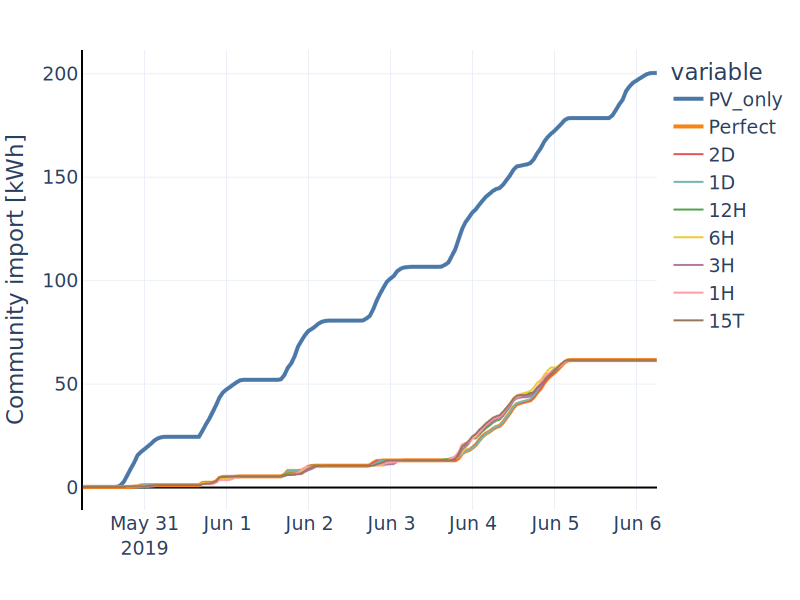

                        PV_only    Perfect         2D         1D        12H  \
Index                                                                         
2019-06-06 06:00:00  200.357695  61.605633  61.605633  61.605633  61.605633   

                            6H         3H         1H        15T  
Index                                                            
2019-06-06 06:00:00  61.605633  61.605633  61.605633  61.605633  


In [38]:
graph = community_import_graph_perfect()
graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end_complete_pred])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
print(graph.tail(1))